In [19]:
from Common.Core.Innovations.DynaNN.v4_auto_scale_input_and_output.dyna_nn_v4 import DynamicNN1d, plot_fitting_result, dyna_train_partial, LaplaceActivation, torch, gpu, nn
import torch.utils.data as Data

In [30]:
# 生成非线性数据
x = torch.linspace(-3, 3, 100).reshape(-1, 1)
noise = torch.randn(*x.shape)
x_outer = torch.linspace(-6, 6, 1000).reshape(-1, 1)
y = 4.2 * (x + 1) ** 2 + 1.1 + noise + 1 * torch.randn(*x.shape) + 10 * torch.sin(x * 15)
# y = (4.2 * (x + 1) ** 2 + 1.1 + 15 * torch.sin(x * 3) + noise + 20 * (x > 0).float() - 10 * (x > 1).float()) / 100
# y = (20 * (x > 0).float() - 10 * (x > 1).float() + 20 * x - 2 * x ** 2) * 80 / 120
y = torch.sin(3 * x) * 40 / 3 * 2
y_outer = 4.2 * (x_outer + 1) ** 2 + 1.1 + 1 * torch.randn(*x_outer.shape) + 10 * torch.sin(x_outer * 15)
dataSet = Data.TensorDataset(x, y)
data_iter = Data.DataLoader(dataSet, batch_size=100, shuffle=True)

In [31]:
# 初始化动态神经网络
dyna_nn = DynamicNN1d(1, 10, 1, LaplaceActivation)
dyna_nn.set_step_optimizer(lr=0.01)
dyna_nn.set_criterion(nn.MSELoss())
dyna_nn.set_device(gpu())

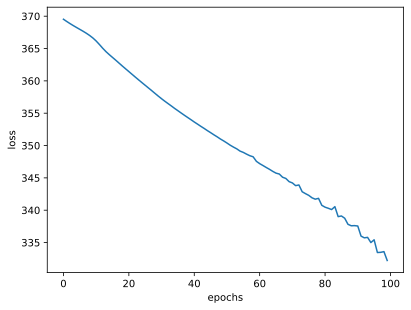

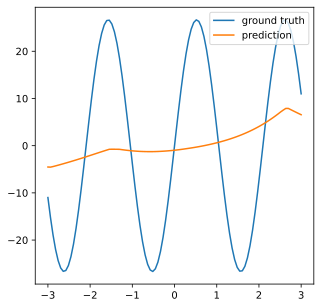

In [32]:
# 动态神经网络初始化单元训练
dyna_nn.train_fixed(data_iter, epochs=100, plot_hist=True)
plot_fitting_result(dyna_nn, x, y)

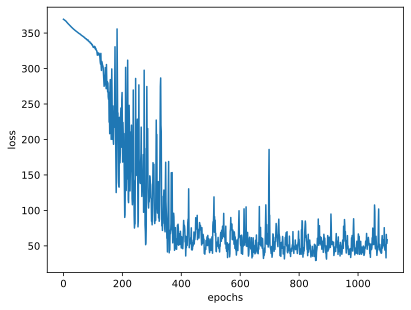

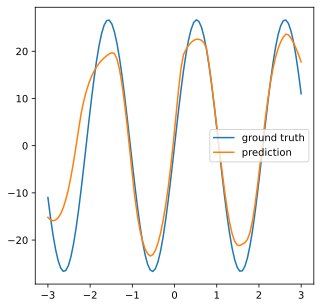

36.643044


In [33]:
# 动态神经网络第一次训练
dyna_train_partial(dyna_nn, LaplaceActivation, LaplaceActivation, 10, data_iter, 0.01, 1000, x, y,
                   lr_decrease=0.2, max_layers=1)

print(dyna_nn.evaluate_loss(data_iter))

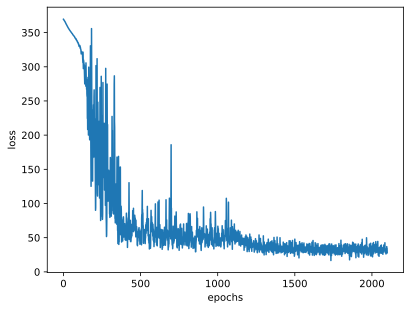

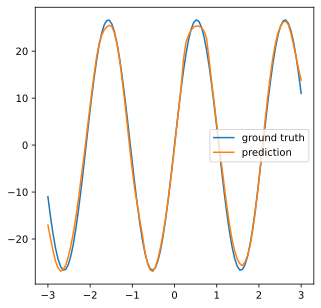

2.053712


In [34]:
# 动态神经网络第二次训练
dyna_train_partial(dyna_nn, LaplaceActivation, LaplaceActivation, 20, data_iter, 0.01, 1000, x, y,
                   lr_decrease=0.2, max_layers=1)

print(dyna_nn.evaluate_loss(data_iter))

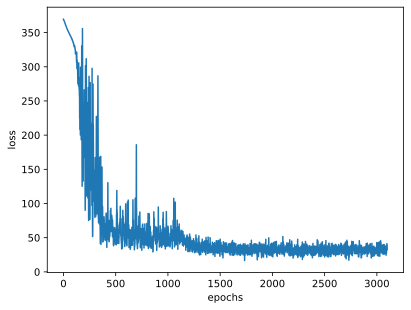

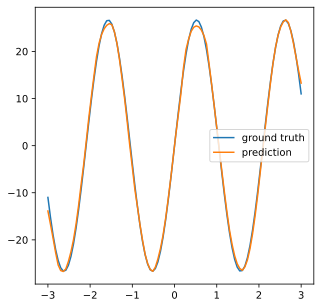

0.49822387


In [35]:
# 动态神经网络第三次训练
dyna_train_partial(dyna_nn, LaplaceActivation, LaplaceActivation, 30, data_iter, 0.01, 1000, x, y,
                   lr_decrease=0.2, max_layers=1)

print(dyna_nn.evaluate_loss(data_iter))

In [29]:
# 大学习率情况
for name, value in dyna_nn.named_parameters():
    print(name)
    print(value)

layers.0.linear1.weight
Parameter containing:
tensor([[-0.5950],
        [ 0.8028],
        [ 0.1553],
        [ 0.9386],
        [-0.1888],
        [-0.1446],
        [ 0.3680],
        [-0.4989],
        [ 0.0834],
        [-0.4637]], requires_grad=True)
layers.0.linear2.weight
Parameter containing:
tensor([[-3.0218,  2.2905,  1.4762, -3.6656, -2.1659, -2.3804, -3.9521, -2.8879,
          0.8417, -2.2281]], requires_grad=True)
layers.0.linear2.bias
Parameter containing:
tensor([0.3544], requires_grad=True)
layers.0.bn.weight
Parameter containing:
tensor([1.3986, 0.6020, 0.6086, 2.8661, 0.5860, 0.6013, 3.1781, 1.5210, 0.4254,
        0.5976], requires_grad=True)
layers.0.bn.bias
Parameter containing:
tensor([-1.2511,  0.0494, -0.1885,  0.7758,  0.0326,  0.0547, -0.9844, -1.0670,
         0.3620, -0.0448], requires_grad=True)
layers.0.activation.a
Parameter containing:
tensor([ 1.4600,  0.0151,  0.0296,  1.2387, -0.0231,  0.1452,  1.1714,  1.4118,
         0.7032, -0.0092], requires_gr

In [36]:
# 小学习率情况
for name, value in dyna_nn.named_parameters():
    print(name)
    print(value)

layers.0.linear1.weight
Parameter containing:
tensor([[ 0.4480],
        [-0.0527],
        [ 0.4092],
        [-0.3331],
        [-0.0424],
        [ 0.9630],
        [ 0.8600],
        [ 0.2472],
        [ 0.4250],
        [ 0.4062]], requires_grad=True)
layers.0.linear2.weight
Parameter containing:
tensor([[ 1.7391,  0.8096,  1.3143, -2.0644, -1.9840,  2.3880,  0.8144, -1.4000,
          0.6272,  1.8111]], requires_grad=True)
layers.0.linear2.bias
Parameter containing:
tensor([-0.4965], requires_grad=True)
layers.0.bn.weight
Parameter containing:
tensor([1.1358, 1.4648, 0.5833, 1.2209, 0.9147, 1.0741, 0.5476, 1.8246, 0.6977,
        1.1280], requires_grad=True)
layers.0.bn.bias
Parameter containing:
tensor([-0.3960, -0.2470, -0.2565,  0.5155,  0.2433,  0.4478, -0.0454,  0.1395,
         0.2194, -0.4311], requires_grad=True)
layers.0.activation.a
Parameter containing:
tensor([1.4742, 1.0335, 0.1035, 1.5615, 0.8609, 0.9240, 0.5676, 0.9582, 0.8075,
        1.3471], requires_grad=True)


## 发现当学习率过大后学习能力明显下降的根本原因：
- 一些基本事实：在神经网络中, 梯度下降法其实等价于误差反向传播： 即首先从代价函数处获得$\Delta Y=lr*\frac{\partial L}{\partial Y}$, 随后以类似于前向传播将$\Delta Y$从后向前按矩阵乘法传递。当经过激活函数时，乘以激活函数在此处激活的斜率，最终得到各权重(或输入节点)对最终loss下降的贡献。
- 由1可知，仅学习率变大时等价于学习率不变而$\frac{\partial L}{\partial Y}$变大，当其变大后，所有权重的变化量$\Delta W$ 也将变大。从模型的权重数值观察发现，较大学习率的那一组模型参数的bn参数大多因为模型权重变化幅度较高的梯度导致模型难以正常收敛，从而导致模型迅速将bn的scale和bias增加并且提升了激活函数的衰减系数a和b，从而使得模型大部分节点进入激活函数的"激活死亡"区域，导致模型实质上什么也没学到。(称之为神经元死亡保护)